In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
    , names=header,
    index_col=False)

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


In [ ]:
slice = ["age", "yredu", "capgain", "caploss", "workhr"]
subdf = df[slice]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


In [ ]:
np.sum(subdf["caploss"])

2842700

In [ ]:
#Iterate through the columns
for col in slice:
  #Calculate max, min, and average of each column
  max = np.max(subdf[col])
  min = np.min(subdf[col])
  average = np.average(subdf[col])
  #Print max, min, average
  print(col+" | Max:" + str(max) + " | Min:"  +
                          str(min) + " | Average:" +
                          str(average) +"\n")
  #Normalize
  df[col] = (df[col]-min)/(max-min)

#Why are some negative???
subdf2 = df[slice]
subdf2[:3] # show the first 3 records



age | Max:90 | Min:17 | Average:38.58164675532078

yredu | Max:16 | Min:1 | Average:10.0806793403151

capgain | Max:99999 | Min:0 | Average:1077.6488437087312

caploss | Max:4356 | Min:0 | Average:87.303829734959

workhr | Max:99 | Min:1 | Average:40.437455852092995



,age,yredu,capgain,caploss,workhr
0,0.301370,0.800000,0.02174,0.0,0.397959
1,0.452055,0.800000,0.00000,0.0,0.122449
2,0.287671,0.533333,0.00000,0.0,0.397959


In [ ]:
num_males = sum(df["sex"] == " Male")
num_females = sum(df["sex"] == " Female")
total = num_males + num_females
print(str((num_males/total) * 100) + "% of people in the dataset are male")
print(str((num_females/total) * 100) + "% of people in the dataset are male")

66.92054912318419% of people in the dataset are male
33.07945087681583% of people in the dataset are male


In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [ ]:
num_missing = df_with_missing.shape[0]
# because df has been modified to exclude missing records
total_num = df.shape[0] + num_missing
percent= (num_missing / total_num) * 100
print(str(num_missing) + " records contained missing features")
print(str(percent) + "% of records were removed")

1843 records contained missing features
5.356935240088362% of records were removed


In [ ]:
values = set(df_not_missing['work'])
print("All possible values of work: " + str(values))

All possible values of work: {' Local-gov', ' Federal-gov', ' Private', ' State-gov', ' Self-emp-not-inc', ' Without-pay', ' Self-emp-inc'}


In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0.452055,0.800000,0.00000,0.0,0.122449,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
2,0.287671,0.533333,0.00000,0.0,0.397959,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,True


In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
 # Mapping of feature -> start index of feature in a record
cat_index = {}
# Mapping of feature -> list of categorical values the feature can take
cat_values = {}

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    return cat_values[feature][np.argmax(onehot)]

print(get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work"))
print(get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work"))

In [ ]:


def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
#Split the data
#Please note that the dataset does not split perfectly cleanly
#30,718 * 0.7 = 21,502.6 | 30,718 * 0.15 = 4,607.7
split_data = torch.utils.data.random_split(datanp, [0.7, 0.15, 0.15])
train_data = split_data[0]
val_data = split_data[1]
test_data = split_data[2]
print("Size of Training set: " + str(len(train_data)))
print("Size of Validation set: " + str(len(val_data)))
print("Size of Test set: " + str(len(test_data)))

Size of Training set: 21503
Size of Validation set: 4608
Size of Test set: 4607


In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self, name = "AutoEncoder"):
        super(AutoEncoder, self).__init__()
        self.name = "AutoEncoder"
        self.encoder = nn.Sequential(
            nn.Linear(57, 43),
            nn.Linear(43, 29),
            nn.Linear(29, 15)
        )
        self.decoder = nn.Sequential(
            nn.Linear(15, 29),
            nn.Linear(29, 43),
            nn.Linear(43, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, val_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        for data in train_loader:
            #zero out one categorical feature
            datam = zero_out_random_feature(data.clone())
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # track training and validation accuracy and loss
        train_loss[epoch] = get_loss(model, train_loader, criterion)
        val_loss[epoch] = get_loss(model, val_loader, criterion)
        train_acc[epoch] = get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, val_loader)

        #output accuracy
        print(("Epoch: {} | Training acc: {} |" + "Validation acc: {}"
               + " | Training loss: {} | Validation loss: {}"
        ).format(epoch, train_acc[epoch], val_acc[epoch], train_loss[epoch],
                 val_loss[epoch]))

        #checkpoint model
        model_path = get_model_name(model.name, learning_rate,
                                    epoch)
        torch.save(model.state_dict(), model_path)

    epochs = np.arange(1, num_epochs + 1)
    return(epochs, train_acc, val_acc, train_loss, val_loss)


#Get model name for checkpointing
def get_model_name(name, learning_rate, epoch):
   path = "model_{0}_lr{1}_epoch{2}".format(name,
                                                  learning_rate, epoch)
   return path


def get_loss(model, data_loader, criterion):
  total_loss = 0
  i = 0
  for data in data_loader:
    #zero out one categorical feature
    datam = zero_out_random_feature(data.clone())
    recon = model(datam)
    loss = criterion(recon, data)
    total_loss += loss.item()
    i += 1

  return total_loss/(i + 1)

#plot loss
def plot_loss_curve(num_epochs, train_loss, val_loss):
    plt.title("Loss Curve")
    n = len(num_epochs)
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

#plot accuracy
def plot_accuracy_curve(num_epochs, train_acc, val_acc):
    plt.title("Accuracy Curve")
    n = len(num_epochs) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid,
        batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=256,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=256,
                                         shuffle=True)

Epoch: 0 | Training acc: 0.2729851648607171 |Validation acc: 0.27079716435185186
Epoch: 1 | Training acc: 0.28952549256692867 |Validation acc: 0.2875434027777778
Epoch: 2 | Training acc: 0.40766404687717994 |Validation acc: 0.40889033564814814
Epoch: 3 | Training acc: 0.4582306344851106 |Validation acc: 0.4602864583333333
Epoch: 4 | Training acc: 0.4582306344851106 |Validation acc: 0.4602864583333333
Epoch: 5 | Training acc: 0.4582306344851106 |Validation acc: 0.4602864583333333
Epoch: 6 | Training acc: 0.4617805267482057 |Validation acc: 0.4646267361111111
Epoch: 7 | Training acc: 0.46139298392472367 |Validation acc: 0.46372251157407407
Epoch: 8 | Training acc: 0.4610674479529988 |Validation acc: 0.46361400462962965
Epoch: 9 | Training acc: 0.4752360135795005 |Validation acc: 0.47728587962962965
Epoch: 10 | Training acc: 0.5150056581252228 |Validation acc: 0.5179398148148148
Epoch: 11 | Training acc: 0.5287246740764855 |Validation acc: 0.5313223379629629
Epoch: 12 | Training acc: 0.53

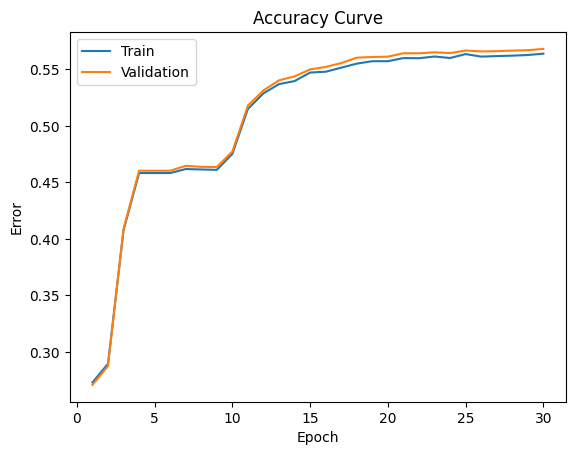

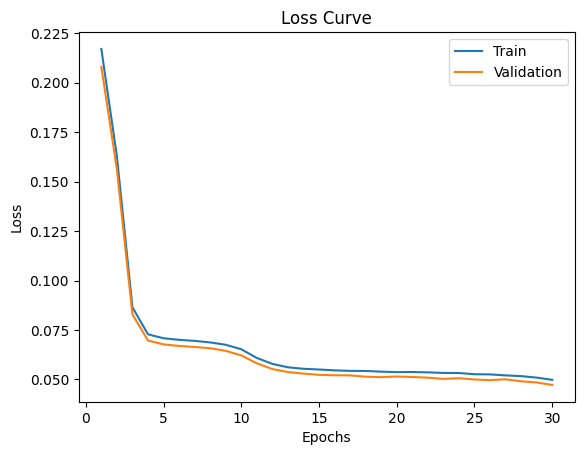

In [ ]:
#Baseline hyperparameters: batch size = 256, epochs = 30,
#learning rate = 1e-4
model = AutoEncoder()
epochs, train_acc, val_acc, train_loss, val_loss = train(
    model, train_loader, val_loader, num_epochs=30, learning_rate=1e-4)
#plot training curves
plot_accuracy_curve(epochs, train_acc, val_acc)
plot_loss_curve(epochs, train_loss, val_loss)

In [ ]:
model2 = AutoEncoder()
epochs, train_acc, val_acc, train_loss, val_loss = train(
    model2, train_loader, val_loader, num_epochs=37, learning_rate=1e-3)

In [ ]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=256,
                                          shuffle=True)

In [ ]:
print(get_accuracy(model2, test_loader))
#Test accuracy is ~60.25%

0.6025251428984878


In [ ]:
#Define baseline model
def baseline(data_loader, catcols, cat_values, cat_index):
    # Find the most common value for each feature in the training set
    predictions = []
    most_common_values = {}
    for col in catcols:
      most_common_values[col] = df[col].mode()[0]

    total_predictions = 0
    correct_predictions = 0

    for batch in data_loader:
        batch_df = pd.DataFrame(batch)

        for index, row in batch_df.iterrows():
            row_vec = row.to_numpy()

            for col in catcols:
                # Zero out the feature in row_mod
                start_index = cat_index[col]
                stop_index = cat_index[col] + len(cat_values[col])
                row_mod = row_vec.copy()
                row_mod[start_index:stop_index] = 0

                # Baseline model prediction
                if np.sum(row_mod[start_index:stop_index]) == 0:
                    mode = str(most_common_values[col]).strip()
                    pred = np.zeros(len(cat_values[col]))
                    pred[cat_values[col].index(mode)] = 1
                    row_mod[start_index:stop_index] = pred

                # Extract the actual feature
                actual_feature = row_vec[start_index:stop_index]
                actual_feature_value = cat_values[col][np.argmax(
                    actual_feature)]

                # Extract the predicted feature
                predicted_feature = row_mod[start_index:stop_index]
                predicted_feature_value = cat_values[col][np.argmax(
                    predicted_feature)]

                # Calculate accuracy
                correct_predictions += int(
                    predicted_feature_value == actual_feature_value)
                total_predictions += 1

    accuracy = correct_predictions / total_predictions
    return row_mod, accuracy, most_common_values

x, accuracy, most_common_values = baseline(test_loader, catcols,
                                           cat_values, cat_index)
print("Most common values for each feature in train_set are:\n",
      most_common_values)
print("\nThe accuracy of this model is", round(accuracy * 100, 2), "%")

Most common values for each feature in train_set are:
 {'work': ' Private', 'marriage': ' Married-civ-spouse', 'occupation': ' Prof-specialty', 'edu': ' HS-grad', 'relationship': ' Husband', 'sex': ' Male'}

The accuracy of this model is 46.09 %
